# Lab 3: Decision trees and ensembles
In this session we will introduce decision trees and apply them to a regression problem. We will then describe techniques that combine multiple models into a more accurate ensemble model.

# Decision trees

The idea of a decision tree is to break down our decision (classification or regression) into a sequence of small decisions, each based on a single feature. All the decision points are structured in the form of a tree. Starting at the root and progressing down to the leaves of the tree where we find our prediction. In the case of a classification problem, the leaves store a class probability. For a regression problem, we store actual values in the leaves.

<img src="images/tree.png"/><br/> Example decision tree: https://gdcoder.com/decision-tree-regressor-explained-in-depth/

Advantages of decision trees:
- They are easy to understand. You probably already understand the idea just based on the picture above.
- They can model **non-linear** interactions between features. As you can see in the figure above, they can form non-linear **decision boundaries** in the feature space.
- They are a **whitebox** model. It is easy to understand why the model has made a certain prediction. You can follow all the steps that the model took to obtain the prediction. This is especially useful in medical applications where it is important to be able to explain why a model is making a prediction.
- They are easy to visualize.
- They are very fast, especially at **inference time** (using a trained model to make a prediction). 
- They are easy to implement in any programming language using simple if-else statements.
- They allow you to determine **feature importance**. This is a major benefit, as this improves the **interpretability** and this information could also be used for **feature selection**.
- They can easily be combined into ensembles.
- They support multiple outputs.

Disadvantages of decision trees:
- They are unstable, meaning that a small change in the data can lead to a large change in the structure of the optimal decision tree.
- They are often relatively inaccurate. Many other predictors perform better with similar data. 
- They can be prone to **overfitting**.
- It is often difficult to model a linear relationship between an input feature and the target as decision trees use step functions to group input data points. This is visualized in the figure below, at each internal node in the tree, we have to make a decision. This results in a **piece-wise constant** decision function.
- They lack smoothness, a small change in the input can result in a very different prediction if the input data point lies close to a decision boundary. This can also be seen on the figure below, the prediction for x=19 is very different from the prediction for x=20.

<img src="images/step.png"/><br/> Decision tree for regression: https://towardsdatascience.com/https-medium-com-lorrli-classification-and-regression-analysis-with-decision-trees-c43cdbc58054


## Classification and regression trees (CART)

<img width="400px" src="images/guess.jpg"></img>

Given a dataset of data points, each with a set of features and a target value, we can design multiple decision trees that model this data. Our goal is however to design the smallest, most efficient tree possible. Unfortunately this is an NP-complete problem. There are many algorithms (ID3, C4.5, CART, ...) that result in reasonably good solutions but there is no guarantee that it will be the best possible solution. Most of these techniques follow the same principle: they build the tree in a  **greedy** way, starting with the most **informative** question first. At each level of the tree, we pick the feature that would give us the most information given what we know already. This is similar to the game of "guess who" where you try to predict the identity of your opponent by asking questions. To do this programmatically, we somehow have to quantify the information contained in a set of facts. Encoding this mathematically is the task of **information theory**. 

In this assignment, we will focus on **Classification and regression trees (CART)**. As the name suggests, they can be used both for classification and regression. The CART algorithm iteratively splits the remaining data point in two groups based on a single feature *k* and a threshold *t<sub>k</sub>*. For each possible (*k*, *t<sub>k</sub>*), it calculates a **cost function** and picks the combination with the lowest cost. The cost function is different for classification and regression tasks:

### Classification
Here, we typically use the **Gini impurity**. It measures how **pure** the split is, if all the data points on one side of the split belong to the same class, this part of the tree is pure. The Gini impurity is given by

$Gini\ Impurity = 1 - Gini = 1 - \sum_{i=1}^{n} p_i^2 $
 
Where $n$ is the number of classes and $p_i$ the fraction of the data points belonging to class *i* in this child node. We calculate this for both of the subsets and then sum both values, weighted by the fraction of data points in both splits. 

### Regression
Here, we can not use the impurity anymore. Instead we simply use the **sum-of-squares** error. We pick the split that minimizes the sum of the squared difference between the target values and the mean of the target values in each node.


# The data
We will use a dataset with room information from AirBnB in Amsterdam. Each entry corresponds to an accommodation and contains information such as the number of people that can stay at that location, the number of reviews, the coordinates, the room type, ... . Our task is to predict the price for new locations. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns 
from matplotlib import rcParams

rcParams['figure.figsize'] = 20,16

%matplotlib inline

In [2]:
df = pd.read_json ("amsterdam.json")
df

,host_listings_count,accommodates,bathrooms,bedrooms,guests_included,minimum_nights,number_of_reviews,calculated_host_listings_count,price,latitude,longitude,room_type,instant_bookable
0,1.0,6,1.0,2.0,1,3,4,1,$145.00,52.361173,4.866755,Entire home/apt,f
1,1.0,2,1.0,1.0,1,2,17,1,$88.00,52.370237,4.859507,Entire home/apt,f
2,1.0,2,1.0,1.0,2,2,4,1,$130.00,52.362016,4.866872,Entire home/apt,f
3,2.0,4,1.0,2.0,2,4,2,2,$110.00,52.365826,4.858178,Entire home/apt,f
4,1.0,2,1.0,1.0,1,3,10,1,$115.00,52.364179,4.864885,Entire home/apt,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15176,2.0,4,1.5,1.0,2,1,0,1,$80.00,52.391679,4.779126,Private room,t
15177,1.0,2,1.0,1.0,2,3,0,1,$125.00,52.395505,4.878143,Entire home/apt,t
15178,6.0,16,2.0,0.0,10,2,0,1,$435.00,52.426224,4.959300,Entire home/apt,t
15179,1.0,4,1.5,2.0,2,3,0,1,$80.00,52.354298,4.974295,Entire home/apt,f


In [3]:
df.dtypes

host_listings_count               float64
accommodates                        int64
bathrooms                         float64
bedrooms                          float64
guests_included                     int64
minimum_nights                      int64
number_of_reviews                   int64
calculated_host_listings_count      int64
price                              object
latitude                          float64
longitude                         float64
room_type                          object
instant_bookable                   object
dtype: object

## Data preprocessing
First, we need to preprocess the data to make it easier to use. The price is stored as a string containing a dollar sign, we convert this to a float value. All features are **numerical** except for  "room_type" and "instant-bookable". We will replace the **categorical** room type with a **one-hot** encoding. For the binary feature "instant_bookable", we simply use 0 and 1.  We will also remove the entries with a price higher than 500 to remove outliers. 


In [4]:
# price string to number
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].str.replace('$','')
df["price"] = pd.to_numeric(df["price"])

# Categorical -> one hot
df = pd.get_dummies(df, columns=["room_type"])
df

# Boolean -> 0 and 1
df["instant_bookable"] = (df["instant_bookable"] == "t").astype('int')

# Remove items with a price higher than $500
df=df[df.price<=500.0]
df=df.dropna()

/tmp/ipykernel_11405/2310500886.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price']=df['price'].str.replace('$','')


## Feature engineering
Depending on our application, we might want to design new features based on a combination of existing features. In this case we have the location of each accommodation as latitude and longitude, this is probably not the most informative. We will use this to calculate the distance to the city center instead. You could do something similar to calculate the distance to the nearest train station, public transport, shopping street, ... or anything else that might influence the price.

In [5]:
from math import radians, cos, sin, asin, sqrt

center_latitude=52.379189
center_longitude=4.899431

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km


for index, row in df.iterrows():
    df.loc[index, 'distance'] = haversine(center_longitude, center_latitude, row['longitude'], row['latitude'])

df = df.drop(["latitude", "longitude"], axis=1)

Let's plot the correlations between the feature values and the price of the room.

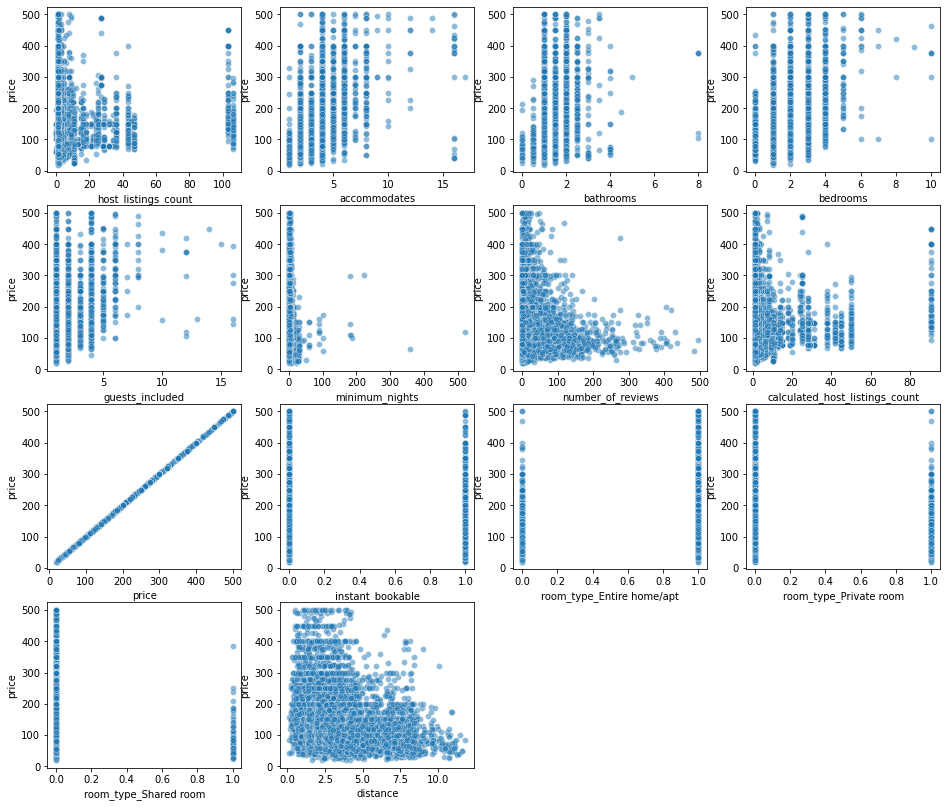

In [6]:
plt.figure(figsize=(16,14))
for i, k in enumerate(df.keys()):
    plt.subplot(4,4,1+i)
    sns.scatterplot(x=df[k], y=df["price"], alpha=0.5)

In [12]:
#sns.catplot(x="bedrooms", y="price", kind="swarm", data=df)

<font color='red'>Task: What can you learn from these plots ?</font>

...
bedroom, distance, reviews, guests

Finally, let's split of a train and test set.

In [7]:
import sklearn.model_selection as model_selection

X = df.drop(['price'],axis=1)
Y = df["price"]

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.25)

# A simple regression tree using CART 
We will implement a simple version of the CART algorithm for regression on this dataset. We start at the root with the full training set. At each node, we have to select a feature and a threshold to split the remaining data. We loop over all features and pick the mean value of the feature for the remaining data as our threshold. We then calculate the loss of this split as describe above. We repeat this for every feature and pick the one that resulted in the lowest loss. We repeat this for every level, making sure that the next levels work on the correct subset of the data. We could continue doing this until only a single data point remains but instead we will limit the height of the tree to a small number like 3, 5 or 8.

<font color='red'>Task: Complete the RegressionTree class and train it on the train set. </font>

In [8]:
class RegressionTree:
    def __init__(self, max_depth=5):
        # Every node in the tree defines a split of the remaining data (a feature + a threshold). Every node has two subtrees 
        # that store the elements based on their values compared to the threshold.
        self.feature = None        # The name of the feature that is used to split the remaining datapoints at this node
        self.value = None          # Either the threshold used to split the datapoints or the value if this node is a leaf
     
        self.left = None           # The left subtree
        self.right = None          # The right subtree
        
        self.max_depth = max_depth # Regularization parameter, how deep is this tree allowed to be
    
    def fit(self, X, Y, feature_names):             
        if self.max_depth > 0 and len(X) > 1:
            # Loop over all features, try to split the remaining data based on this feature and measure how good the split is.
            # Then pick the feature that resulted in the best split
            tableofFN = {}
            for fn in feature_names:
                mean = np.mean(X[fn])
                x_left, x_right = X[X <= mean], X[X>mean]

                indices_left = X[fn] <= mean
                indices_right = ~indices_left

                y_left, y_right = Y[indices_left], Y[indices_right]


                mean_left, mean_right = np.mean(x_left[fn]), np.mean(x_right[fn])


                
            
            
            # Recursively build two child trees for the two subsets        
            self.left = RegressionTree(self.max_depth-1)
            self.right = RegressionTree(self.max_depth-1)
            ....
            
        else:
            # Leaf: just store the mean price value
            self.value = np.mean(Y)
            
    


    def predict(self, features):
        ...
    
    def show(self, level=0):
        if self.left is not None:
            print("\t"*level, self.feature)
            print("\t"*level, "  < ",self.value)
            self.left.show(level+1)
            print("\t"*level, "  > ",self.value)
            self.right.show(level+1)
        else:
            print("\t"*level, "prediction = ",self.value)
        
features = list(df.columns)
features.remove("price") #["distance", "accommodates"]
tree = RegressionTree(max_depth=3)
tree.fit(X_train, Y_train, features)

SyntaxError: invalid syntax (1754736211.py, line 22)

<font color='red'>Task: Does the structure of the tree make sense ?</font>

...

In [ ]:
tree.show()

 bedrooms
   <  1.3980367881146092
	 distance
	   <  2.9360343345076423
		 distance
		   <  1.9197664628039237
			 prediction =  127.35276381909547
		   >  1.9197664628039237
			 prediction =  111.1295799821269
	   >  2.9360343345076423
		 room_type_Entire home/apt
		   <  0.6508633304067896
			 prediction =  71.2615255658005
		   >  0.6508633304067896
			 prediction =  107.47302158273381
   >  1.3980367881146092
	 bedrooms
	   <  2.413322413322413
		 distance
		   <  2.9998006283437935
			 prediction =  179.35413744740532
		   >  2.9998006283437935
			 prediction =  142.31918656056587
	   >  2.413322413322413
		 accommodates
		   <  4.952079566003617
			 prediction =  194.27868852459017
		   >  4.952079566003617
			 prediction =  254.35887096774192


The code below evaluates the tree on the train and test set

Train data


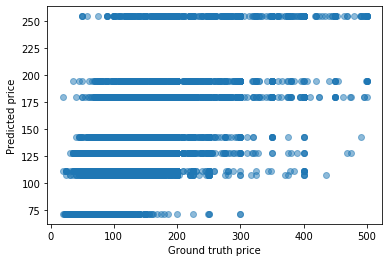

RMSE is 53.747181172605444
R2 score is 0.3781524770792255
Test data


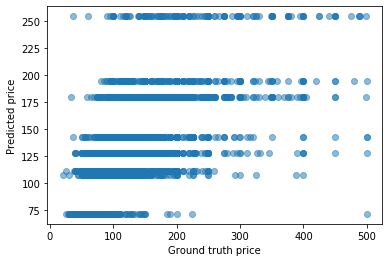

RMSE is 55.987854362358334
R2 score is 0.34234375016492624


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def run_predictions(tree, x):
    predictions = []
    for index, sample in x.iterrows():
        prediction = tree.predict(sample)
        predictions.append(prediction)
    return predictions
    
def visualize_results(predictions, ground_truth):
    
    plt.scatter(ground_truth, predictions, alpha=0.5)
    plt.xlabel("Ground truth price")
    plt.ylabel("Predicted price")
    plt.show()
    
    rmse = (np.sqrt(mean_squared_error(ground_truth, predictions)))
    r2 = r2_score(ground_truth, predictions)
    print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))

print("Train data")
predictions = run_predictions(tree, X_train)
visualize_results(predictions, Y_train)

print("Test data")
predictions = run_predictions(tree, X_test)
visualize_results(predictions, Y_test)

The choice of the maximal depth is a **hyper parameter**. The plot below shows the train and test error for a tree with increasing depth.

<font color='red'>Task: What do we see here ?</font>

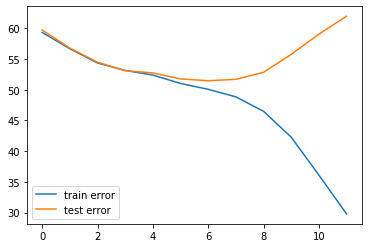

In [ ]:
rmse_train = []
rmse_test = []

for depth in range(1, 13):
    tree = RegressionTree(max_depth=depth)
    tree.fit(X_train, Y_train, features)
    
    predictions = run_predictions(tree, X_train)
    rmse_train.append((np.sqrt(mean_squared_error(Y_train, predictions))))
    
    predictions = run_predictions(tree, X_test)
    rmse_test.append((np.sqrt(mean_squared_error(Y_test, predictions))))
    
plt.plot(rmse_train, label="train error")
plt.plot(rmse_test, label="test error")
plt.legend()
plt.show()

# Bias-variance trade-off
As we increase the depth of the tree, we allow for more complex **decision boundaries**. We could keep increasing the depth until we can perfectly model each training data point but this usually results in severe **overfitting** where we model noise in the training data set, resulting in low performance on new data, as visualized below. We can formalize it using the concept of **Bias-variance trade-off**. All mistakes made by machine learning models are caused by two types of errors:
- **bias errors**: caused by invalid assumptions in the model (e.g. there is a perfect linear relationship between the number of bathrooms and the price of the room). This is **underfitting**.
- **variance errors**: caused by being too sensitive to small variations in the data. (e.g. if the distance is between 1 and 1.3 km the price is 100, if the distance is between 1.3 and 1.4, the price is 150, if the distance is between 1.4 and 1.5, the price is 100). This is **overfitting**.

The bias-variance trade-off is a central problem in supervised learning. Ideally, one wants to choose a model that both accurately captures the regularities in its training data, but also generalizes well to unseen data. Unfortunately, it is typically impossible to do both simultaneously. High-variance learning methods may be able to represent their training set well but are at risk of overfitting to noisy or unrepresentative training data. In contrast, algorithms with high bias typically produce simpler models that may fail to capture important regularities (i.e. underfit) in the data.

<img src="images/Overfitting.png"/><br/>


# Regression tree using scikit-learn
Since decision trees are so common, scikit-learn includes a good implementation of the CART algorithm. The code bellows uses the *DecisionTreeRegressor* to model the data.

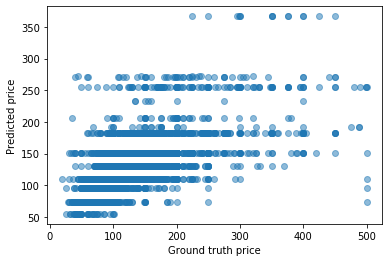

RMSE is 53.75388570538059
R2 score is 0.3937789250570356


In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

model = DecisionTreeRegressor(max_depth=4)
model = model.fit(X_train, Y_train)
predictions = model.predict(X_test)

visualize_results(predictions, Y_test)

We can also visualize the tree.

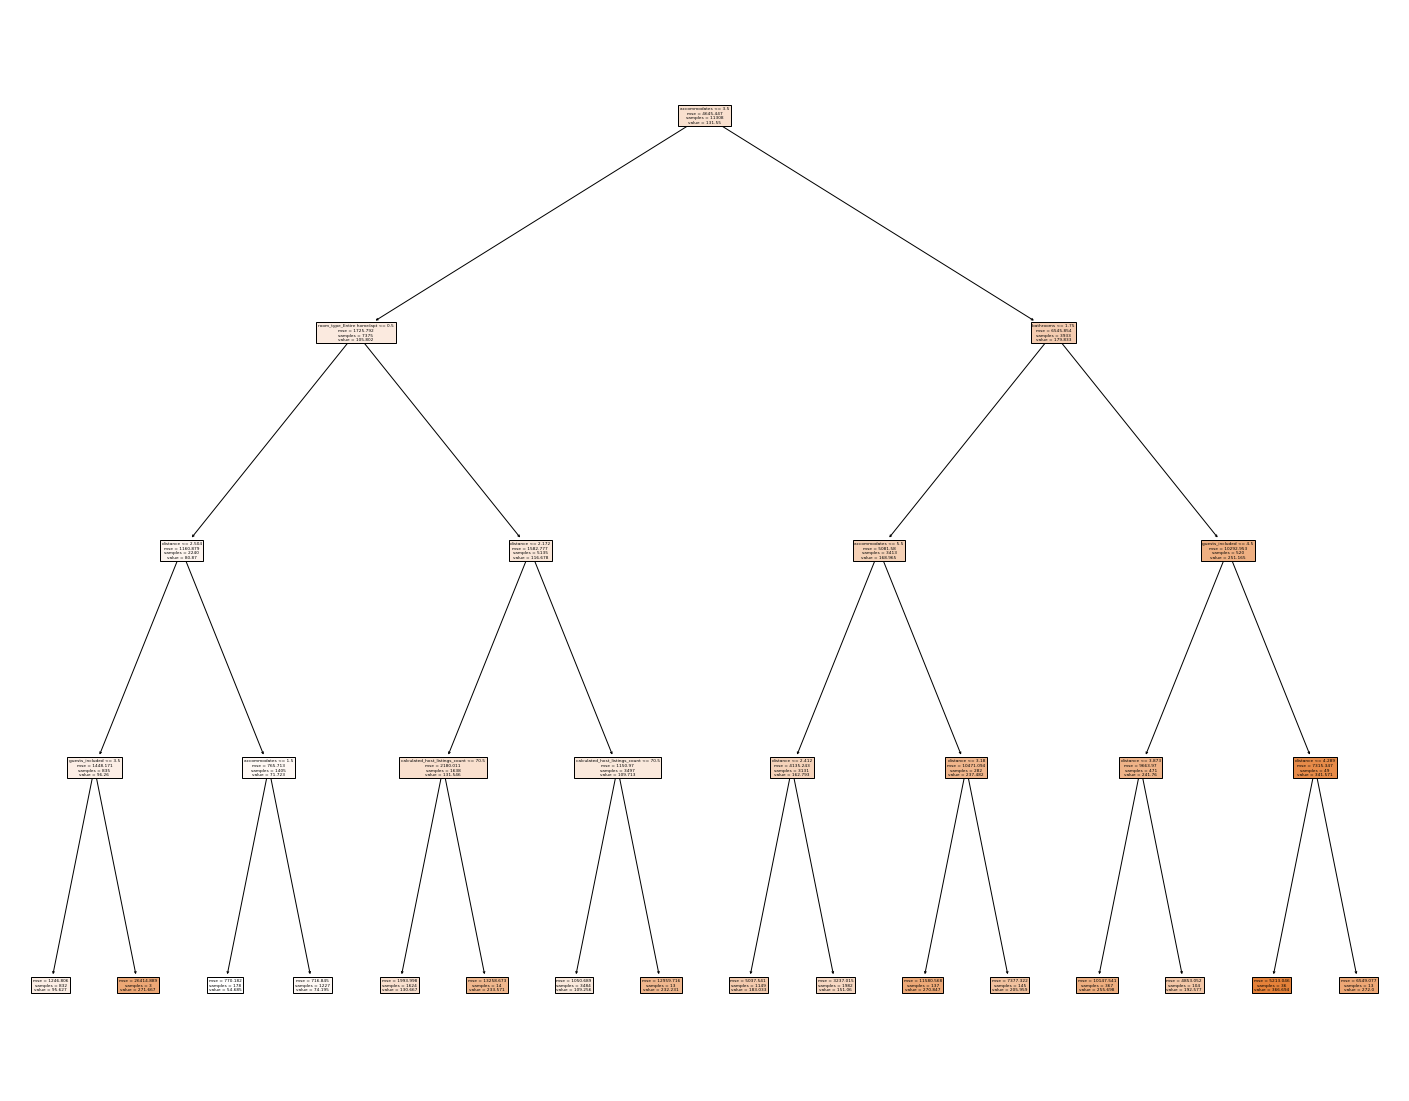

In [ ]:
fig = plt.figure(figsize=(25,20))

_ = plot_tree(model, filled=True, feature_names = X_train.columns)

A major benefit of decision trees is that they allow us to determine the relative feature importance. This is calculated as the total contribution of that feature to the reduction of the loss. We typically normalize this to sum to one. Inspecting the feature importance can allow us to better understand the model. In the scikit-learn implementation, you can easily access these feature importances using the feature_importances_ attribute.

<font color='red'>Task: Do these feature importances make sense ?</font>

In [ ]:
imp_feat=pd.Series(model.feature_importances_,index=X_train.columns.tolist())
imp_feat.sort_values(ascending=False)

accommodates                      0.530401
distance                          0.131700
bathrooms                         0.106088
room_type_Entire home/apt         0.068349
bedrooms                          0.063611
guests_included                   0.038940
calculated_host_listings_count    0.022953
number_of_reviews                 0.018827
minimum_nights                    0.010935
host_listings_count               0.007121
room_type_Private room            0.000927
instant_bookable                  0.000149
room_type_Shared room             0.000000
dtype: float64

# Ensemble learning

The idea of ensemble learning is simple: combine many (weaker) models and aggregate the predictions into a more accurate prediction. The intuition is that every model will make slightly different mistakes but averaged out over multiple models, the prediction should be more accurate. A group of predictors is called an **ensemble** or a **committee**. There are many popular ensemble methods such as **bagging**, **voting**, **boosting** and **stacking**. To successfully apply ensemble methods we have to make sure that the individual models are complementary (they learn slightly different things). We then have to figure out a way to combine the predictions of the individual models.
We will compare three families of ensemble methods: **Averaging methods**, **boosting methods** and **stacking methods**.

## Averaging methods
Averaging methods train many independent models and then combine the predictions using **Voting**. You simply take the predictions of multiple models and return the **majority vote** (the **mode**). This is known as **hard voting**. You could also return the average predicted probabilities (**soft voting**). In the case of a regression problem, we typically return the average prediction although you could also return the median. To encourage the different models to make slightly different predictions, we can train them on slightly different training data. Some common approaches are :
- **Bagging**: Stands for **bootstrap aggregating**. A bootstrap sample is a statistical term for taking a sample from a dataset **with replacement**. This means that it is possible to use the same sample multiple times. Each individual model is trained on a different selection of these samples and will perform slightly different. 
- **Pasting**: Similar to bagging except you sample **without replacement**. A sample can still be used multiple times by different models but it can only be selected once for a specific model.
- **Random Subspaces**: Here you generate slightly different input datasets for each model by selecting a different subset of the features. 
- **Random Patches**: A combination of Bagging and Random subspaces: you select both random datapoint and random feature subsets.

A very common example is a **Random forest**. This is an ensemble of Decision Trees, generally trained via the bagging method. There are two random aspects to a random forest that encourage the individual trees to make different predictions. The first is caused by the bagging which selects random subsets of the data to train each tree on. The second is introduced while growing the trees: instead of searching for the very best feature when splitting a node, as we have done in the first part of this assignment, it searches for the best feature among a random subset of features.

<font color='red'>Task: Does this mean that a Random forest is an ensemble of decision trees using the random patches technique ?</font>

It is possible to include even more randomness by also selecting a random threshold at each split point. The resulting model is called an **extremely random tree ensemble** or **Extra tree** for short. These are very fast to train since you don't need to find the optimal threshold anymore, yet they often perform surprisingly well.

<font color='red'>Task: Train a Random forest and and Extra tree (using their Scikit-learn implementation) on this regression task and calculate the performance.</font>


In [ ]:
from sklearn.ensemble import RandomForestRegressor

...

visualize_results(predictions, Y_test)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

...

visualize_results(predictions, Y_test)

## Boosting methods
Boosting methods also combine several poor performing models into one accurate ensemble learner but instead of combining independent models, boosting tries to build models that focus on the mistakes that were made by the previous methods. While in the previous techniques the models could be trained in **parallel**, now they have to be trained **sequentially**.

### Gradient Boost
Gradient boost is a very common boosting algorithm. It builds a sequence of models where each model should try to correct the mistakes of the previous models. Gradient boost makes this explicit. Each new model is trained on the **residual error** made by the previous model. Gradient boosting can be used for both regression and classification but is easiest to understand for regression tasks. You simply train a first model on the original training data set and calculate the difference between the target value and the predicted value. You then train a second model, again on the original dataset but now the target is this difference between the ground truth and the prediction of the previous model. 

<font color='red'>Task: Implement the Gradient boost algorithm from scratch. Use scikit-learn DecisionTrees with depth 1 (stumps) in your ensemble.</font>

RMSE is 48.34435095812493
R2 score is 0.5007007385860305


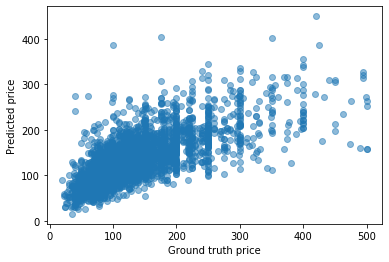

In [ ]:
models = []

...
    
...

    
visualize_results(predictions, Y_test)

### Stacking methods

The Bagging and Boosting methods combine the individual predictions using simple methods such as averaging or voting. It is also possible to train a machine learning algorithm to combine the different predictions into a final prediction. The model that performs the combination is called **a blender** or a **meta learner**. We typically split the training data in two and train the individual models on the first part. We then pass the second part through all these models to generate a training set for the blender model.

<font color='red'>Task: Implement the Stacking algorithm from scratch. Use different types of scikit-learn regression models in your ensemble.</font>

<img src="images/stacking.png" /><br/>
Source: "Hands on Machine Learning with scikit-learn and Tensorflow." (2017).

In [ ]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

models = [
    DecisionTreeRegressor(),
    ExtraTreesRegressor(),
    BayesianRidge(),
    LinearSVR(),
    KNeighborsRegressor()
]

...
    
visualize_results(predictions, Y_test)

We have seen several ensemble methods. Each of them differ in how the individual models are encouraged to behave differently and in how the predictions are combined. Note that it is not uncommon to see implementations that combine several of these approaches. 

<font color='red'>Task: Complete the table below.</font>

| Technique  | How are models encouraged to be different ?  | How are predictions of the models combined ?  | 
|---|---|---|
| Bagging  |  ... | ...  |
| Pasting  |  ... | ...  |
| Random subspaces  | ...  | ... |
| Random patches  | ... | ...  |
| Random forests  | ...  | ...  |
| Extra trees  | ...  | ...  |
| Gradient boost  | ...  | ....  |
| Stacking boost  | ... | ... |

- 